In [1]:
from preprocess import get_prepared_data
import numpy as np
import pandas as pd
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.feature_extraction import ComprehensiveFCParameters
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing

In [2]:
# Load preprocessed, prepared data with original labels
# We want to divide the data into original 5 classes
# And change the shape to (n_samples, 178, 1) because DTW requires 3-dimensional vectors
X, y = get_prepared_data(oversample=False, relabel=False)
X = X.reshape(X.shape[0], X.shape[1], 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [3]:

# Extract features using tsfresh
def extract_tsfresh_features(X, y=None):
    reshaped = pd.DataFrame({
        'id': np.repeat(np.arange(X.shape[0]), X.shape[1]),
        'time': np.tile(np.arange(X.shape[1]), X.shape[0]),
        'value': X.flatten()
    })
    if y is not None:
        reshaped['label'] = np.repeat(y, X.shape[1])
    
    extracted_features = extract_features(
        reshaped,
        column_id='id',
        column_sort='time',
        column_value='value',
        default_fc_parameters=ComprehensiveFCParameters(),
        n_jobs=multiprocessing.cpu_count()
    )
    
    # remove Nan
    extracted_features = extracted_features.dropna(axis=1)
    extracted_features = extracted_features.fillna(0)
    
    return extracted_features


print("Extracting TSFresh features...")
X_train_features = extract_tsfresh_features(X_train, y_train)
X_test_features = extract_tsfresh_features(X_test)

Extracting TSFresh features...


Feature Extraction: 100%|██████████| 60/60 [00:49<00:00,  1.22it/s]


In [4]:
# Random Forest with better features
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

print("Training Random Forest...")
rf_model.fit(X_train_features, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test_features)

Training Random Forest...


In [5]:
# Print the results
def print_results(y_true, y_pred, model_name):
    print(f"\n{model_name} Results:")
    print(classification_report(y_true, y_pred))
    
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()



Random Forest with TSFresh but better Results:
              precision    recall  f1-score   support

           1       0.97      0.97      0.97       456
           2       0.75      0.72      0.73       455
           3       0.76      0.76      0.76       455
           4       0.93      0.88      0.91       456
           5       0.84      0.92      0.88       455

    accuracy                           0.85      2277
   macro avg       0.85      0.85      0.85      2277
weighted avg       0.85      0.85      0.85      2277



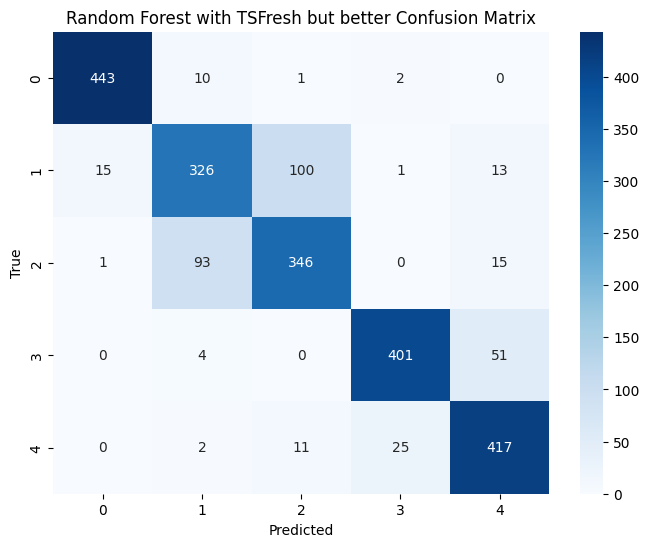

In [6]:
print_results(y_test, y_pred_rf, "Random Forest with TSFresh but better")